In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import logging
import argparse
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error
import tensorflow as tf

import seaborn as sns
sns.set_context('notebook')

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata


In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
questions = label_metadata.decals_questions
label_cols = label_metadata.decals_label_cols
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [5]:
# vols_loc = 'current_final_dr2_result.parquet'
# predictions_loc = 'latest_ml_catalog_dr2_only.parquet'

vols_loc = 'dr5_volunteer_catalog.parquet'
predictions_loc = 'latest_ml_catalog_dr5_only.parquet'

df = pd.read_parquet(predictions_loc)
vols = pd.read_parquet(vols_loc)


In [6]:
len(df), len(vols)

(343128, 253286)

## check how concentrations are saved

In [7]:
concentration_cols = [a.text + '_concentration' for a in schema.answers]

model_samples = dirichlet_stats.load_all_concentrations(df, concentration_cols=concentration_cols)
model_samples.shape

(343128, 34, 25)

In [8]:
model_samples[:2]

array([[[ 18.8731,  22.7141,  20.7146, ...,  19.2746,  17.2702,
          20.24  ],
        [ 39.0552,  51.8402,  43.3618, ...,  47.6503,  50.7568,
          49.1436],
        [  3.5365,   3.58  ,   3.7669, ...,   3.428 ,   3.174 ,
           3.3053],
        ...,
        [ 14.1546,  12.8948,  11.3041, ...,  10.956 ,  13.2517,
          13.7787],
        [  4.6987,   4.8144,   3.9932, ...,   3.0759,   3.9815,
           4.4002],
        [  1.4204,   1.4245,   1.6515, ...,   1.8388,   1.3708,
           1.4527]],

       [[100.2998, 100.9084,  98.8625, ...,  93.6138,  97.1214,
          98.0764],
        [ 11.3494,  11.9764,  11.8131, ...,  11.2342,  10.7406,
          10.8478],
        [ 21.192 ,  21.4996,  19.7249, ...,  21.7716,  20.1621,
          20.9065],
        ...,
        [  2.9335,   2.95  ,   3.8461, ...,   3.225 ,   3.2483,
           3.2491],
        [  1.1221,   1.0583,   1.162 , ...,   1.2025,   1.2027,
           1.1894],
        [  1.1054,   1.1007,   1.181 , ...,   1.

## check a particular example

In [9]:
index = 2

In [10]:
for answer_n, answer in enumerate(schema.answers):
    print('{}: {:.2f}'.format(answer.text, df.loc[index, answer.text + '_fraction']))

smooth-or-featured_smooth: 0.80
smooth-or-featured_featured-or-disk: 0.09
smooth-or-featured_artifact: 0.11
disk-edge-on_yes: 0.08
disk-edge-on_no: 0.92
has-spiral-arms_yes: 0.04
has-spiral-arms_no: 0.96
bar_strong: 0.02
bar_weak: 0.04
bar_no: 0.94
bulge-size_dominant: 0.05
bulge-size_large: 0.27
bulge-size_moderate: 0.61
bulge-size_small: 0.06
bulge-size_none: 0.01
how-rounded_round: 0.87
how-rounded_in-between: 0.12
how-rounded_cigar-shaped: 0.01
edge-on-bulge_boxy: 0.16
edge-on-bulge_none: 0.09
edge-on-bulge_rounded: 0.75
spiral-winding_tight: 0.61
spiral-winding_medium: 0.28
spiral-winding_loose: 0.11
spiral-arm-count_1: 0.06
spiral-arm-count_2: 0.20
spiral-arm-count_3: 0.15
spiral-arm-count_4: 0.12
spiral-arm-count_more-than-4: 0.13
spiral-arm-count_cant-tell: 0.34
merging_none: 0.90
merging_minor-disturbance: 0.06
merging_major-disturbance: 0.02
merging_merger: 0.02


In [11]:
# Image.open(df.iloc[index]['local_png_loc'])

## Check these are consistent with the eval predictions from performance_metrics.ipynb

No need to repeat the performance checks etc. if so.

In [12]:
com = pd.merge(df, vols, on='iauname', suffixes=('_ml', ''), how='inner')

In [13]:
assert len(vols) == len(com)

In [14]:
retired = com[com['smooth-or-featured_total-votes'] >= 30]

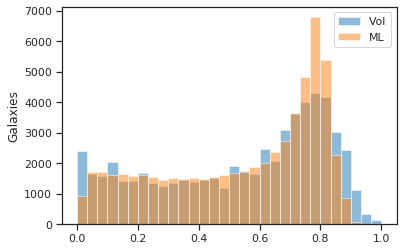

In [15]:
sns.set_style('ticks')
_, bins = np.histogram(np.linspace(0., 1.), bins=30)
plt.hist(retired['smooth-or-featured_smooth_fraction'], alpha=.5, bins=bins, label='Vol')
plt.hist(retired['smooth-or-featured_smooth_fraction_ml'], alpha=.5, bins=bins, label='ML')
plt.ylabel('Galaxies')
plt.legend()

(0.0, 1.0)

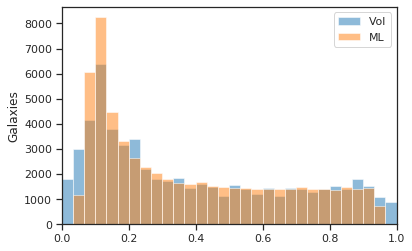

In [16]:
sns.set_style('ticks')
_, bins = np.histogram(np.linspace(0., 1.), bins=30)
plt.hist(retired['smooth-or-featured_featured-or-disk_fraction'], alpha=.5, bins=bins, label='Vol')
plt.hist(retired['smooth-or-featured_featured-or-disk_fraction_ml'], alpha=.5, bins=bins, label='ML')
plt.ylabel('Galaxies')
plt.legend()
plt.xlim([0., 1.])

Text(0, 0.5, 'ML "Smooth" fraction')

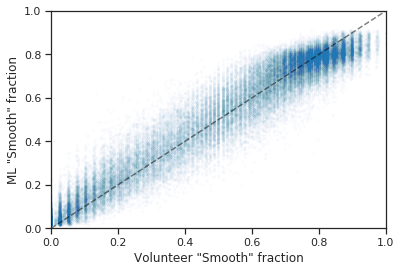

In [17]:
plt.scatter(retired['smooth-or-featured_smooth_fraction'], retired['smooth-or-featured_smooth_fraction_ml'], alpha=.01, s=5.)
plt.plot([0., 1.], [0., 1.], 'k--', alpha=.5)
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel('Volunteer "Smooth" fraction')
plt.ylabel('ML "Smooth" fraction')

Text(0, 0.5, 'ML "Spiral" fraction')

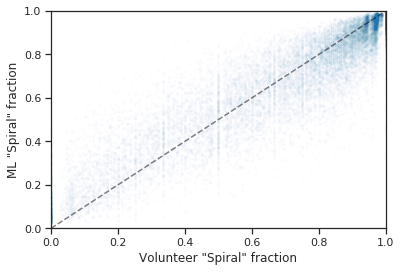

In [18]:
featured = retired[(retired['disk-edge-on_no_fraction'] > 0.5) & (retired['smooth-or-featured_smooth_fraction'] <= 0.5)]
plt.scatter(featured['has-spiral-arms_yes_fraction'], featured['has-spiral-arms_yes_fraction_ml'], alpha=.01, s=5.)
plt.plot([0., 1.], [0., 1.], 'k--', alpha=.5)
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel('Volunteer "Spiral" fraction')
plt.ylabel('ML "Spiral" fraction')

In [19]:
# sneakily save the sample table

cols_for_table = [
    'iauname',
    'ra',
    'dec',
    'bar_proportion_volunteers_asked',
    'bar_weak_concentration',
    'bar_weak_fraction_ml',
]
header = [
    'iauname',
    'RA',
    'Dec',
    r'bar\_proportion_\asked',
    r'bar\_weak\_concentration',
    r'bar\_weak\_fraction\_ml}'
]
print(retired.head()[cols_for_table].to_latex(header=header, index=False, escape=False, float_format="%.2f", na_rep='-'))

\begin{tabular}{lrrrlr}
\toprule
             iauname &     RA &   Dec & bar\_proportion_\asked &                           bar\_weak\_concentration & bar\_weak\_fraction\_ml} \\
\midrule
 J223312.48-004356.5 & 338.30 & -0.73 &                   0.58 &  [14.1343, 14.8318, 14.3146, 14.7398, 15.5076, ... &                     0.27 \\
 J223243.92+002350.6 & 338.18 &  0.40 &                   0.05 &  [8.3506, 10.5864, 8.4589, 9.3074, 10.6027, 7.4... &                     0.19 \\
 J223220.06+004935.8 & 338.08 &  0.83 &                   0.83 &  [13.7433, 13.6744, 10.4392, 12.2348, 11.8433, ... &                     0.34 \\
 J223026.55-002026.7 & 337.61 & -0.34 &                   0.88 &  [11.2915, 10.3134, 10.3501, 11.2459, 10.9568, ... &                     0.23 \\
 J223745.50+003109.4 & 339.44 &  0.52 &                   0.65 &  [9.1742, 8.13, 6.4903, 9.0055, 8.6326, 10.9552... &                     0.12 \\
\bottomrule
\end{tabular}



In [20]:
# sneakily save the sample table

cols_for_table = [
    'iauname',
    'ra',
    'dec',
    'bar_proportion_volunteers_asked',
    'bar_weak_concentration',
    'bar_weak_fraction_ml',
]
header = [
    'iauname',
    'RA',
    'Dec',
    r'bar\_proportion_\asked',
    r'bar\_weak\_concentration',
    r'bar\_weak\_fraction\_ml}'
]
print(retired.head()[cols_for_table].to_latex(header=header, index=False, escape=False, float_format="%.2f", na_rep='-'))

\begin{tabular}{lrrrlr}
\toprule
             iauname &     RA &   Dec & bar\_proportion_\asked &                           bar\_weak\_concentration & bar\_weak\_fraction\_ml} \\
\midrule
 J223312.48-004356.5 & 338.30 & -0.73 &                   0.58 &  [14.1343, 14.8318, 14.3146, 14.7398, 15.5076, ... &                     0.27 \\
 J223243.92+002350.6 & 338.18 &  0.40 &                   0.05 &  [8.3506, 10.5864, 8.4589, 9.3074, 10.6027, 7.4... &                     0.19 \\
 J223220.06+004935.8 & 338.08 &  0.83 &                   0.83 &  [13.7433, 13.6744, 10.4392, 12.2348, 11.8433, ... &                     0.34 \\
 J223026.55-002026.7 & 337.61 & -0.34 &                   0.88 &  [11.2915, 10.3134, 10.3501, 11.2459, 10.9568, ... &                     0.23 \\
 J223745.50+003109.4 & 339.44 &  0.52 &                   0.65 &  [9.1742, 8.13, 6.4903, 9.0055, 8.6326, 10.9552... &                     0.12 \\
\bottomrule
\end{tabular}



In [21]:
retired.columns.values

array(['iauname', 'png_loc_ml', 'smooth-or-featured_smooth_concentration',
       'smooth-or-featured_featured-or-disk_concentration',
       'smooth-or-featured_artifact_concentration',
       'disk-edge-on_yes_concentration', 'disk-edge-on_no_concentration',
       'has-spiral-arms_yes_concentration',
       'has-spiral-arms_no_concentration', 'bar_strong_concentration',
       'bar_weak_concentration', 'bar_no_concentration',
       'bulge-size_dominant_concentration',
       'bulge-size_large_concentration',
       'bulge-size_moderate_concentration',
       'bulge-size_small_concentration', 'bulge-size_none_concentration',
       'how-rounded_round_concentration',
       'how-rounded_in-between_concentration',
       'how-rounded_cigar-shaped_concentration',
       'edge-on-bulge_boxy_concentration',
       'edge-on-bulge_none_concentration',
       'edge-on-bulge_rounded_concentration',
       'spiral-winding_tight_concentration',
       'spiral-winding_medium_concentration',
   

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Vols - ML "Smooth" fraction')

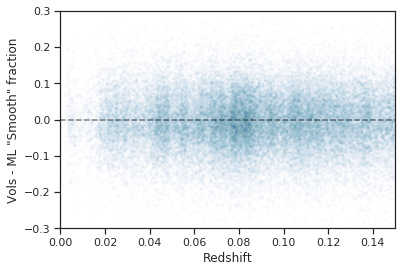

In [22]:
retired['smooth_fraction_error'] = retired['smooth-or-featured_smooth_fraction'] - retired['smooth-or-featured_smooth_fraction_ml']
plt.scatter(retired['redshift'], retired['smooth_fraction_error'], alpha=.01, s=5.)
plt.axhline(0., color='k', linestyle='--', alpha=.5)
plt.xlim([0., .15])
plt.ylim([-.3, .3])
plt.xlabel('Redshift')
plt.ylabel('Vols - ML "Smooth" fraction')

In [23]:
retired["elpetro_absmag_r_correct"] = retired["elpetro_absmag_r"]+ 5*np.log10(0.7)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
retired["elpetro_absmag_r_correct"] = retired["elpetro_absmag_r_correct"].replace(np.inf, np.nan)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


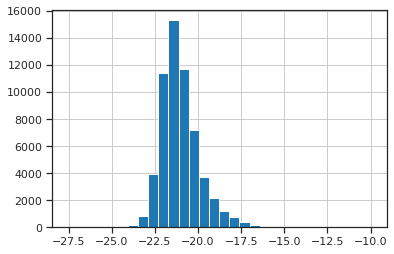

In [25]:
retired["elpetro_absmag_r_correct"].hist(bins=30)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Vols - ML "Smooth" fraction')

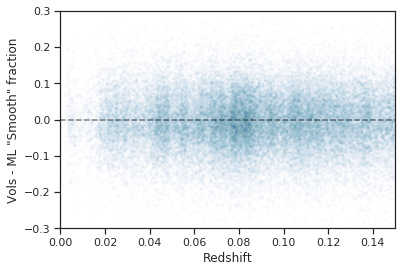

In [26]:
retired['smooth_fraction_error'] = retired['smooth-or-featured_smooth_fraction'] - retired['smooth-or-featured_smooth_fraction_ml']

plt.scatter(retired['redshift'], retired['smooth_fraction_error'], alpha=.01, s=5.)
plt.axhline(0., color='k', linestyle='--', alpha=.5)
plt.xlim([0., .15])
plt.ylim([-.3, .3])
plt.xlabel('Redshift')
plt.ylabel('Vols - ML "Smooth" fraction')

In [27]:
retired["elpetro_absmag_r_correct_0dp"] = np.around(retired["elpetro_absmag_r_correct"])

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


-18 1465
-20 9533
-22 19206
-23 2914


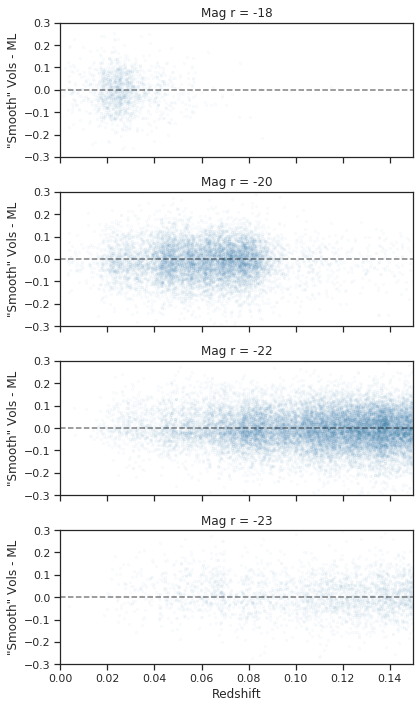

In [28]:
fig, axes = plt.subplots(nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for n, mag in enumerate([-18, -20, -22, -23]):
    mag_df = retired[retired['elpetro_absmag_r_correct_0dp'] == mag]
    print(mag, len(mag_df))
    ax = axes[n]
    ax.scatter(mag_df['redshift'], mag_df['smooth_fraction_error'], alpha=.02, s=5.)
    ax.axhline(0., color='k', linestyle='--', alpha=.5)
    ax.set_xlim([0., .15])
    ax.set_ylim([-.3, .3])
    ax.set_title('Mag r = {}'.format(mag))
    ax.set_ylabel('"Smooth" Vols - ML')
ax.set_xlabel('Redshift')
fig.tight_layout()

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Vols - ML "Winding=Tight" fraction')

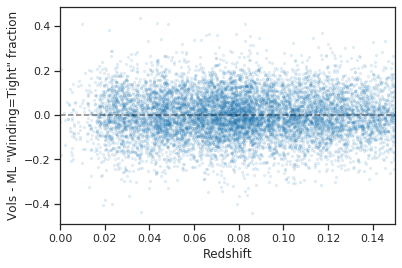

In [29]:
winding = retired[retired['spiral-winding_proportion_volunteers_asked'] > 0.5]
winding['winding_tight_fraction_error'] = winding['spiral-winding_tight_fraction'] - winding['spiral-winding_tight_fraction_ml']
plt.scatter(winding['redshift'], winding['winding_tight_fraction_error'], alpha=.1, s=5.)
plt.axhline(0., color='k', linestyle='--', alpha=.5)
plt.xlim([0., .15])
# plt.ylim([-.3, .3])
plt.xlabel('Redshift')
plt.ylabel('Vols - ML "Winding=Tight" fraction')

-18 62
-20 1146
-22 3997
-23 553


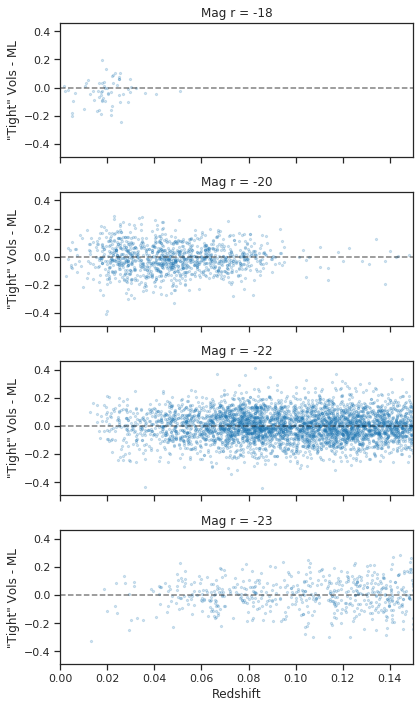

In [30]:
fig, axes = plt.subplots(nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for n, mag in enumerate([-18, -20, -22, -23]):
    mag_df = winding[winding['elpetro_absmag_r_correct_0dp'] == mag]
    print(mag, len(mag_df))
    ax = axes[n]
    ax.scatter(mag_df['redshift'], mag_df['winding_tight_fraction_error'], alpha=.2, s=5.)
    ax.axhline(0., color='k', linestyle='--', alpha=.5)
    ax.set_xlim([0., .15])
#     ax.set_ylim([-.3, .3])
    ax.set_title('Mag r = {}'.format(mag))
    ax.set_ylabel('"Tight" Vols - ML')
ax.set_xlabel('Redshift')
fig.tight_layout()

In [31]:
winding.columns.values

array(['iauname', 'png_loc_ml', 'smooth-or-featured_smooth_concentration',
       'smooth-or-featured_featured-or-disk_concentration',
       'smooth-or-featured_artifact_concentration',
       'disk-edge-on_yes_concentration', 'disk-edge-on_no_concentration',
       'has-spiral-arms_yes_concentration',
       'has-spiral-arms_no_concentration', 'bar_strong_concentration',
       'bar_weak_concentration', 'bar_no_concentration',
       'bulge-size_dominant_concentration',
       'bulge-size_large_concentration',
       'bulge-size_moderate_concentration',
       'bulge-size_small_concentration', 'bulge-size_none_concentration',
       'how-rounded_round_concentration',
       'how-rounded_in-between_concentration',
       'how-rounded_cigar-shaped_concentration',
       'edge-on-bulge_boxy_concentration',
       'edge-on-bulge_none_concentration',
       'edge-on-bulge_rounded_concentration',
       'spiral-winding_tight_concentration',
       'spiral-winding_medium_concentration',
   

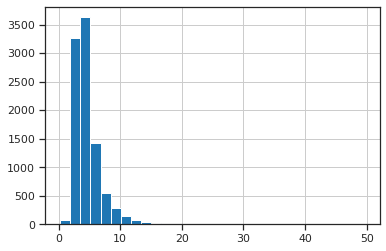

In [32]:
winding['petro_th50'].hist(bins=30)

In [33]:
winding['petro_th50_0dp'] = np.around(winding['petro_th50'], 0)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
len(winding) / len(retired)

0.1608439927869626

2 741
3 2512
6 831
10 136


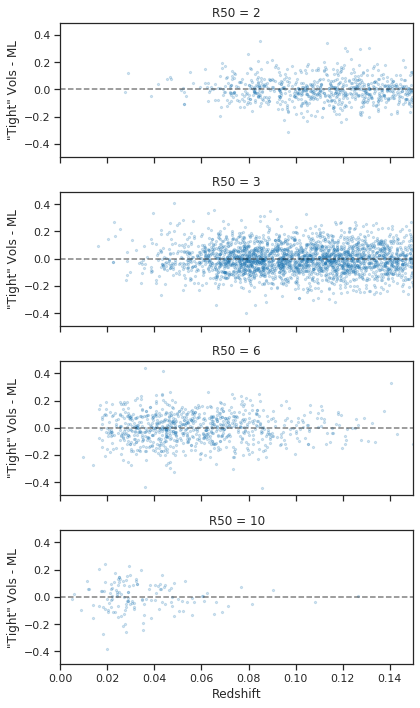

In [35]:
fig, axes = plt.subplots(nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for n, mag in enumerate([2, 3, 6, 10]):
    mag_df = winding[winding['petro_th50_0dp'] == mag]
    print(mag, len(mag_df))
    ax = axes[n]
    ax.scatter(mag_df['redshift'], mag_df['winding_tight_fraction_error'], alpha=.2, s=5.)
    ax.axhline(0., color='k', linestyle='--', alpha=.5)
    ax.set_xlim([0., .15])
#     ax.set_ylim([-.3, .3])
    ax.set_title('R50 = {}'.format(mag))
    ax.set_ylabel('"Tight" Vols - ML')
ax.set_xlabel('Redshift')
fig.tight_layout()